# MATH 522 Final Exam - Joy Song - 4/16/2020

In [1]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel
from causalgraphicalmodels import CausalGraphicalModel
from causalgraphicalmodels.csm import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model, logistic_model
sns.set_style("whitegrid")
sns.set_palette("colorblind")
%matplotlib inline

In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/bin/'

# Problem of Interest
Given a data set with 500 samples and the following eight variables: 

**GRE** (GRE scores), **TF** (TOEFL scores), **UR** (university rating), **SOP** (Statement of Purpose strength), **LOR** (Letter of Recommendation strength), **GPA** (undergraduate GPA), **Research** (have research experience or not), **Admit** (chance of admittance),

we are interested in the causal relationships between them, especially the causal influence on the variable **Admit** (the chance of admittance).

In [3]:
# read data, credit to Elliot
path = 'graduate_admissions'
filename = 'Admission_Predict_Ver1.1.csv'
filepath = os.path.join(path, filename)

df = pd.read_csv(filepath)
df.drop(columns='Serial No.', inplace=True)
df.columns = ['GRE', 'TF', 'UR', 'SOP', 'LOR', 'GPA', 'Research', 'Admit']
df.head()

,GRE,TF,UR,SOP,LOR,GPA,Research,Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
# describe data
df.describe()

,GRE,TF,UR,SOP,LOR,GPA,Research,Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


# Causal Graphical Model
We start with constructing a causal graphical model which is a Bayesian network where the directed edges indicate the causal relationships between nodes. 

## Correlation
In order to make appropriate causal assupmtions, we need to investigate the correlations between these eight variables.

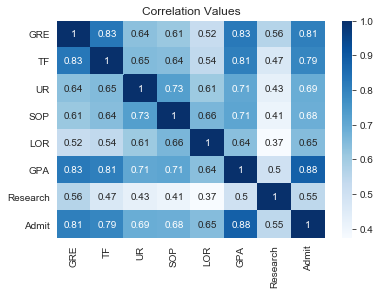

In [5]:
# compute correlations, credit to Elliot
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Values')
plt.show()

strongly correlated (>=0.8): **GRE** & **TF**, **GRE** & **GPA**, **GRE** & **Admit**, **TF** & **GPA**, **GPA** & **Admit**;

correlated (0.7~0.8): **TF** & **Admit**, **UR** & **SOP**, **UR** & **GPA**, **SOP** & **GPA**;

## Causal Assumptions

Based on our prior knowledge and intuition about these variables, we exhasut all possible causal assumptions and construct the following ***graduate model***: 

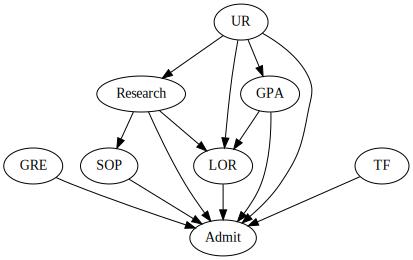

In [6]:
# graduate model: a causal graphical model where each node is observed
grad = CausalGraphicalModel(
    nodes=["GRE","TF","UR","SOP","LOR","GPA","Research","Admit"],
    edges=[
        ("GRE","Admit"),
        ("TF","Admit"),
        ("UR","Admit"),
        ("SOP","Admit"),
        ("LOR","Admit"),
        ("GPA","Admit"),
        ("Research","Admit"),
        ("UR","GPA"),                # better universities might be more strict
        ("UR","LOR"),                # some of the letters are written by the professors at the university
        ("UR","Research"),           # better universities might require research experience 
        ("GPA","LOR"),               # some professors take GPA into consideration while writing letters
        ("Research","LOR"),          # some letters are from the professors the students did research with
        ("Research","SOP")           # research experience might polish the statement of purpose
    ]
)

grad.draw()

This model, however, does not explain the strong correlations between the three variables **GRE**, **TF** and **GPA**. Given the fact that they do not apply any causal influence on each other, this correlation is interpreted as due to some hidden common "parent" of the three variables, for example, the ability on exams.

Therefore, combining the correlation information with this causal model, we propose the following ***latent graduate model*** where the four variables **GRE**, **TF**, **GPA** and **UR** are assumued to have an *unobserved* parent: **AB** ( the ability on exams):

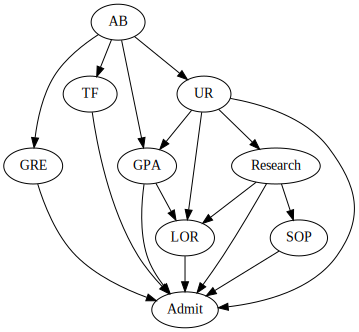

In [7]:
# latent graduate model: a causal graphical model contaning unobserved nodes
grad_latent = CausalGraphicalModel(
    nodes=["AB","GRE","TF","UR","SOP","LOR","GPA","Research","Admit"],
    edges=[
        ("AB","GRE"),
        ("AB","TF"),
        ("AB","GPA"),
        ("AB","UR"),
        ("GRE","Admit"),
        ("TF","Admit"),
        ("UR","Admit"),
        ("SOP","Admit"),
        ("LOR","Admit"),
        ("GPA","Admit"),
        ("Research","Admit"),
        ("UR","GPA"),                # better universities might be more strict
        ("UR","LOR"),                # some of the letters are written by the professors at the university
        ("UR","Research"),           # better universities might require research experience 
        ("GPA","LOR"),               # some professors take GPA into consideration while writing letters
        ("Research","LOR"),          # some letters are from the professors the students did research with
        ("Research","SOP")           # research experience might polish the statement of purpose
    ]
)

grad_latent.draw()

# Structural Causal Model

In order to do inference on this model, we need to designate certain structural relationships between the variables. In other words, we hope to find the set of CPDs associated with this Bayesian network.

## Continuous Model

The continuous model assumes that all the variabls are continuous except **Research** (dummy variable).

### Structural Assumptions

For the nodes without parents (**GRE**, **TF**, **UR**) in the ***graduate model***, we shouldn't assume that they are independently distributed due to the fact that they are strongly correlated. We utilize the ***latent graduate model*** where the three nodes have a common parent **AB**. Although the variable **AB** is unobserved, but we are able to assume that people's abilities on exams are normally distributed. We choose standard normal distribution believing that linear regression would pick the appropriate parameters:

$\mathbf{AB} \sim \mathcal{N}(0,1)$

Given a student's ability on exams, this student's performances on GRE, TF, and college entrance exams are assumed to be normally distributed, this means that we obtain the following three CPDs:

$\mathbf{GRE} | \mathbf{AB} \sim \mathcal{N}(\mu_{gre},\sigma^2_{gre}),\quad \mathbf{TF}|\mathbf{AB}\sim \mathcal{N}(\mu_{tf},\sigma^2_{tf}),\quad \mathbf{UR}|\mathbf{AB} \sim \mathcal{N}(\mu_{ur},\sigma^2_{ur})$

For the variable **GPA**, we also assume that it's normally distributed given the university rating and student's ability on exams:

$\mathbf{GPA}|\mathbf{AB},\mathbf{UR} \sim \mathcal{N}(\mu_{gpa},\sigma^2_{gpa})$

For the binary variable **Research**, assume that it follows Bernoulli distribution when the university rating is given:

$P(\mathbf{Research} = 1|\mathbf{UR}) = p_{re}, \quad P(\mathbf{Research} = 0|\mathbf{UR}) = 1 - p_{re}$

The variable **SOP** has only one parent which is the binary variable **Research**. The assumption is that having research experiences will polish a student's SOP to some extent, hence the normally distributed **SOP** will have a slightly higher mean value when conditioned on **Research** = 1. Denote the affect of research experience on SOP strength as $\delta(\mathbf{Research})$ then we have

$\mathbf{SOP} \sim \mathcal{N}(\mu_{sop}+\delta(\mathbf{Research}),\sigma^2_{sop})$

The variable **LOR** has three parents: **UR**, **GPA** and **Research**, it's normally distributed as a linear combination of **UR** and **GPA**, and it's also affected by **Research**. Denote the affect of research experience on LOR strength as $\Delta(\mathbf{Research})$ then we have

$\mathbf{LOR}|\mathbf{UR},\mathbf{GPA} \sim \mathcal{N}(\mu_{lor}+\Delta(\mathbf{Research}),\sigma^2_{lor})$

### Parameters Learning

Develop fitting models for each variable that are able to take any values of parents as input.

One problem about our idea of the continuous model is, all the variables except **Research** are modeled as continuous variables under no constraint, while some variables (**UR**, **SOP** and **LOR**) in the dataset only take on finite number of values, and all of the variables stay in a certain range:

**GRE**: integers from 260 to 340

**TF**: integers from 0 to 120

**UR**: five fixed values: 1, 2, 3, 4, 5

**GPA**: real values from 6.00 to 10.00

**SOP**: nine fixed values: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5

**LOR**: nine fixed values: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5

**Admit**: real values from 0.00 to 1.00

To address this problem, after predicting **UR**, **SOP** and **LOR**, we will convert the continuous values into categorical values based on their quantiles. For the other continuous variables, we will force those out-of-range values to be the maximum or minimum values.

In [8]:
# Given any AB, fit a GRE distribution and predict
# force GRE values to be integers in [260,340]
def fit_gre_cont(AB,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_gre = smf.ols('GRE ~ AB', data = dataset).fit()
    pred = LR_gre.predict(pd.DataFrame({'AB':AB})['AB'])
    pred = round(pred)
    pred[pred < 260] = 260
    pred[pred > 340] = 340
    return pred

In [9]:
# Given any AB, fit a TF distribution and predict
# force TL values to be integers in [0,120]
def fit_tf_cont(AB,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_tl = smf.ols('TF ~ AB', data = dataset).fit()
    pred = LR_tl.predict(pd.DataFrame({'AB':AB})['AB'])
    pred = round(pred)
    pred[pred < 0] = 0
    pred[pred > 120] = 120
    return pred

In [10]:
# Given any AB, fit a UR distribution and predict
# convert continuous UR values into integers from 1 to 5
def fit_ur_cont(AB,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_ur = smf.ols('UR ~ AB', data = dataset).fit()
    pred = LR_ur.predict(pd.DataFrame({'AB':AB})['AB'])
    pred = pd.qcut(pred,5,labels=False)+1
    return pred

In [11]:
# Given any AB, fit a GPA distribution and predict given any UR
# force GPA values to stay in [6,10]
def fit_gpa_cont(AB,UR,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_gpa = smf.ols('GPA ~ AB + UR', data = dataset).fit()
    pred = LR_gpa.predict(pd.DataFrame({'AB':AB,'UR':UR})[['AB','UR']])
    pred[pred < 6] = 6
    pred[pred > 10] = 10
    return pred

In [12]:
# fit a Research distribution and predict given any UR
# use logistic regression for the binary Research
def fit_re_cont(UR,n_samples):
    LR_re = smf.logit('Research ~ UR', data = df).fit()
    pred = LR_re.predict(pd.DataFrame({'UR':UR})['UR'])
    pred = [ 0 if x < 0.5 else 1 for x in pred]
    return pred

In [13]:
# given any BS, fit a SOP distribution and predict given any Research
# convert continuous SOP values into 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5
def fit_sop_cont(Research,BS,n_samples):
    dataset = df.copy(deep=True)
    dataset['BS'] = BS[0:len(df)]
    LR_sop = smf.ols('SOP ~ C(Research) + BS', data = dataset).fit()
    pred = LR_sop.predict(pd.DataFrame({'Research':Research,'BS':BS})[['Research','BS']])
    pred = (pd.qcut(pred,9,labels=False)+2)/2
    return pred

In [14]:
# fit a LOR distribution and predict given any UR, GPA, Research
# convert continuous LOR values into 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5
def fit_lor_cont(Research,UR,GPA,n_samples):
    LR_lor = smf.ols('LOR ~ C(Research) + UR + GPA', data = df).fit()
    pred = LR_lor.predict(pd.DataFrame({'Research':Research,'UR':UR,'GPA':GPA})[['Research','UR','GPA']])
    pred = (pd.qcut(pred,9,labels=False)+2)/2
    return pred

In [15]:
# fit a Admit distribution and predict given any Research,GRE,TF,UR,GPA,SOP,LOR
# force Admit values to stay in [0,1]
def fit_ad_cont(Research,GRE,TF,UR,GPA,SOP,LOR,n_samples):
    LR_ad = smf.ols('Admit ~ C(Research) + GRE + TF + UR + GPA + SOP + LOR', data = df).fit()
    pred = LR_ad.predict(pd.DataFrame({'Research':Research,'GRE':GRE,'TF':TF,'UR':UR,'GPA':GPA,
                                      'SOP':SOP,'LOR':LOR})[['Research','GRE','TF','UR','GPA','SOP','LOR']])
    pred[pred < 0] = 0
    pred[pred > 1] = 1
    return pred

### Continuous Model Setup

In [16]:
grad_cont = StructuralCausalModel({
    "BS": lambda n_samples: np.random.normal(size = n_samples),  # base normal distribution for sop
    "AB": lambda n_samples: np.random.normal(size = n_samples),
    "GRE": lambda AB, n_samples: fit_gre_cont(AB,n_samples),
    "TF": lambda AB, n_samples: fit_tf_cont(AB,n_samples),
    "UR": lambda AB, n_samples: fit_ur_cont(AB,n_samples),
    "GPA": lambda AB, UR, n_samples: fit_gpa_cont(AB,UR,n_samples),
    "Research": lambda UR, n_samples: fit_re_cont(UR,n_samples),
    "SOP": lambda Research, BS, n_samples: fit_sop_cont(Research,BS,n_samples),
    "LOR": lambda Research, UR, GPA, n_samples: fit_lor_cont(Research,UR,GPA,n_samples),
    "Admit": lambda Research, GRE, TF, UR, GPA, SOP, LOR, n_samples: fit_ad_cont(Research,GRE,TF,UR,GPA,SOP,LOR,n_samples)
})

In [17]:
gs_cont = grad_cont.sample(500).drop(columns = ['AB','BS'])
gs_cont.head()

Optimization terminated successfully.
         Current function value: 0.587163
         Iterations 5


,UR,Research,GPA,LOR,TF,GRE,SOP,Admit
0,5,1,9.300996,5.0,108.0,318.0,5.0,0.862639
1,4,1,8.911357,3.5,107.0,317.0,4.0,0.779059
2,5,1,9.294356,4.5,108.0,317.0,3.5,0.849186
3,3,1,8.534287,3.0,107.0,316.0,3.5,0.717397
4,1,0,7.752073,1.0,106.0,314.0,1.0,0.544427


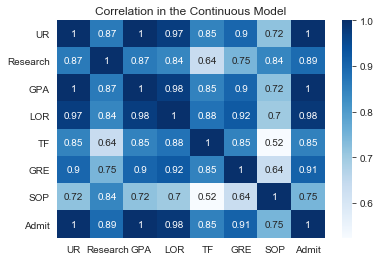

In [18]:
sns.heatmap(gs_cont.corr(), cmap='Blues', annot=True)
plt.title('Correlation in the Continuous Model')
plt.show()

## Discrete Model

With the following features of our data, the continuous model first treat them as continuous variables, then convert them into the corresponding format, which could result in large errors:

**GRE**: integers from 260 to 340

**TF**: integers from 0 to 120

**UR**: five fixed values: 1, 2, 3, 4, 5

**GPA**: real values from 6.00 to 10.00

**Research**: binary variable

**SOP**: nine fixed values: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5

**LOR**: nine fixed values: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5

**Admit**: real values from 0.00 to 1.00

Therefore, we condiser a discrete model which directly treats **UR**, **SOP** and **LOR** as categorical variables.

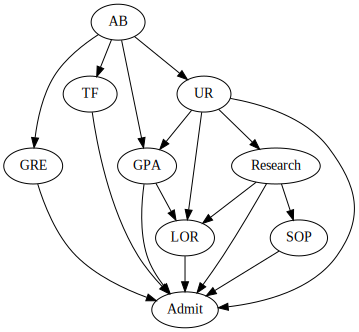

In [19]:
grad_latent.draw()

### Structural Assumptions

For continuous variables, we still assume that **GRE** and **TF** are normally distributed given **AB**

$\mathbf{AB} \sim \mathcal{N}(0,1), \quad \mathbf{GRE} | \mathbf{AB} \sim \mathcal{N}(\mu_{gre},\sigma^2_{gre}),\quad \mathbf{TF}|\mathbf{AB}\sim \mathcal{N}(\mu_{tf},\sigma^2_{tf})$

**UR** is regarded as a categorical variable taking values 1,2,3,4,5:

$P(\mathbf{UR} = k | \mathbf{AB}) = p_{ur}(k),\quad \sum_{k=1}^5p_{ur}(k) = 1$

The variable **GPA** is still assumed to be normally distributed given **UR** and **AB**

$\mathbf{GPA}|\mathbf{AB},\mathbf{UR} \sim \mathcal{N}(\mu_{gpa},\sigma^2_{gpa})$

This time for the binary variable **Research**, since the parent **UR** is treated as a categorical variable, we are able to entirely specify it's discrete distribution:

$P(\mathbf{Research} = 1|\mathbf{UR} = k) = p_{re}(k), \quad P(\mathbf{Research} = 0|\mathbf{UR} = k) = 1 - p_{re}(k), \quad k = 1,2,3,4,5$

For the variable **SOP**, since it has a binary parent **Research**, when treated as a categorical variable, we are able to entirely specify its discrete distribution:

$s_1 = 1, \quad s_2 = 1.5, \quad s_3 = 2, \quad s_4 = 2.5, \quad s_5 = 3, \quad s_6 = 3.5, \quad s_7 = 4, \quad s_8 = 4.5, \quad s_9 = 5$

$P(\mathbf{SOP}=s_i|\mathbf{Research}=j) = p_{i,j}, \quad \forall i = 1,2,\dots,9, \forall j = 0,1 \quad \Rightarrow \quad \sum_{i=1}^9p_{i,j} = 1, \quad \forall j = 0,1$

For the categorical variable **LOR**, it has both discrete parents (**Research**, **UR**) and continuous parents (**GPA**), hence we have:

$(\mathbf{LOR} = s_i|\mathbf{Research} = j, \mathbf{UR} = k,\mathbf{GPA}) \sim \mathcal{N}(\mu_{lor}(s_i,j,k),\sigma^2_{lor})$


### Parameters Learning

In [20]:
# same as fit_gre_cont
def fit_gre_disc(AB,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_gre = smf.ols('GRE ~ AB', data = dataset).fit()
    pred = LR_gre.predict(pd.DataFrame({'AB':AB})['AB'])
    pred = round(pred)
    pred[pred < 260] = 260
    pred[pred > 340] = 340
    return pred

In [21]:
# same as fit_tf_cont
def fit_tf_disc(AB,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_tl = smf.ols('TF ~ AB', data = dataset).fit()
    pred = LR_tl.predict(pd.DataFrame({'AB':AB})['AB'])
    pred = round(pred)
    pred[pred < 0] = 0
    pred[pred > 120] = 120
    return pred

In [22]:
# Given any AB, fit a UR distribution and predict
# use multinomial logistic regression
def fit_ur_disc_1(AB,n_samples):
    LR_ur = LogisticRegression(random_state=0).fit(sm.add_constant(AB[0:len(df)]), np.array(df['UR']))
    AB = sm.add_constant(AB)
    pred = LR_ur.predict(AB)
    return pred

# It turns out that using multinomial logistic regression is problematic
# most of the predictions are the same
# so this is an alternative model for UR which does not depend on AB
def fit_ur_disc_2(n_samples):
    ur_prob = [sum(df['UR'] == i)/len(df) for i in range(1,6)]
    return np.random.choice([1,2,3,4,5],n_samples,p=ur_prob)

In [23]:
# same as fit_gpa_cont except that UR now is treated as a categorical variable
def fit_gpa_disc(AB,UR,n_samples):
    dataset = df.copy(deep=True)
    dataset['AB'] = AB[0:len(df)]
    LR_gpa = smf.ols('GPA ~ AB + C(UR)', data = dataset).fit()
    pred = LR_gpa.predict(pd.DataFrame({'AB':AB,'UR':UR})[['AB','UR']])
    pred[pred < 6] = 6
    pred[pred > 10] = 10
    return pred

In [24]:
# credit to Joseph
# specify the discrete distribution for Research given UR
df_ur = [df[df['UR'] == i] for i in range(1,6)]
re_prob = [[sum(seg['Research'] == i)/len(seg) for i in np.arange(2)] for seg in df_ur]

def fit_re_disc(UR,n_samples):
    pred = np.zeros(n_samples)
    for i in np.arange(n_samples):
        pred[i] = np.random.binomial(1, re_prob[UR[i]-1][1], 1)[0]
    return pred.astype(int)

In [25]:
# credit to Joseph
# specify the discrete distribution for SOP given Research
df_re = [df[df['Research'] == i] for i in np.arange(2)]
sop_prob = [[sum(seg['SOP'] == i)/len(seg) for i in np.arange(1,5.5,.5)] for seg in df_re]

def fit_sop_disc(Research,n_samples):
    pred = np.zeros(n_samples)
    for i in np.arange(n_samples):
        element = [1,2,3,4,5,6,7,8,9]  # need to be treated as categorical data, cannot use original values
        pred[i] = np.random.choice(element,1,p=sop_prob[int(Research[i])])[0]
    return pred

In [26]:
# same as fit_lor_cont except that now UR is treated as a categorical variable
def fit_lor_disc(Research,UR,GPA,n_samples):
    LR_lor = smf.ols('LOR ~ C(Research) + C(UR) + GPA', data = df).fit()
    pred = LR_lor.predict(pd.DataFrame({'Research':Research,'UR':UR,'GPA':GPA})[['Research','UR','GPA']])
    pred = pd.qcut(pred,9,labels=False)+1  # generate integers from 1 to 9
    return pred

In [27]:
# same as fit_ad_cont except that now
# UR,SOP,LOR are treated as categorical variables
def fit_ad_disc(Research,GRE,TF,UR,GPA,SOP,LOR,n_samples):
    dataset = df.copy(deep=True)
    dataset['SOP'] = dataset['SOP'] * 2 - 1
    dataset['LOR'] = dataset['LOR'] * 2 - 1
    LR_ad = smf.ols('Admit ~ C(Research) + GRE + TF + C(UR) + GPA + C(SOP) + C(LOR)', data = dataset).fit()
    pred = LR_ad.predict(pd.DataFrame({'Research':Research,'GRE':GRE,'TF':TF,'UR':UR,'GPA':GPA,
                                      'SOP':SOP,'LOR':LOR})[['Research','GRE','TF','UR','GPA','SOP','LOR']])
    pred[pred < 0] = 0
    pred[pred > 1] = 1
    return pred

In [28]:
grad_disc = StructuralCausalModel({
    "AB": lambda n_samples: np.random.normal(size = n_samples),
    "GRE": lambda AB, n_samples: fit_gre_disc(AB,n_samples),
    "TF": lambda AB, n_samples: fit_tf_disc(AB,n_samples),
    "UR": lambda AB, n_samples: fit_ur_disc_1(AB,n_samples),
    "GPA": lambda AB, UR, n_samples: fit_gpa_disc(AB,UR,n_samples),
    "Research": lambda UR, n_samples: fit_re_disc(UR,n_samples),
    "SOP": lambda Research, n_samples: fit_sop_disc(Research,n_samples),
    "LOR": lambda Research, UR, GPA, n_samples: fit_lor_disc(Research,UR,GPA,n_samples),
    "Admit": lambda Research, GRE, TF, UR, GPA, SOP, LOR, n_samples: fit_ad_disc(Research,GRE,TF,UR,GPA,SOP,LOR,n_samples)
})

In [29]:
gs_disc = grad_disc.sample(500).drop(columns = ['AB'])
gs_disc.head()

,UR,Research,SOP,GPA,LOR,TF,GRE,Admit
0,3,0,3.0,8.498560,2,107.0,316.0,0.627321
1,3,0,7.0,8.503058,4,107.0,316.0,0.690064
2,3,1,8.0,8.498520,6,107.0,316.0,0.726188
3,3,0,3.0,8.494979,1,107.0,316.0,0.609097
4,3,1,6.0,8.505800,9,107.0,316.0,0.739896


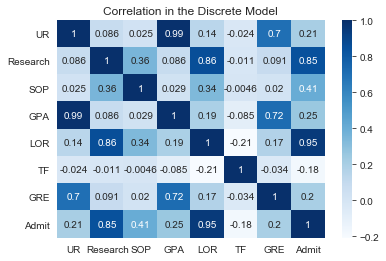

In [30]:
sns.heatmap(gs_disc.corr(), cmap='Blues', annot=True)
plt.title('Correlation in the Discrete Model')
plt.show()

# Intervention Query

We are interested in the intervention query $P(\mathbf{Admit}|do(\mathbf{Research}=1))$, which is the probability of admittance if we force a student to have reasearch experience.

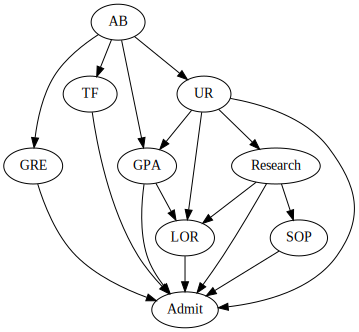

In [31]:
grad_latent.draw()

## the Multilated Network

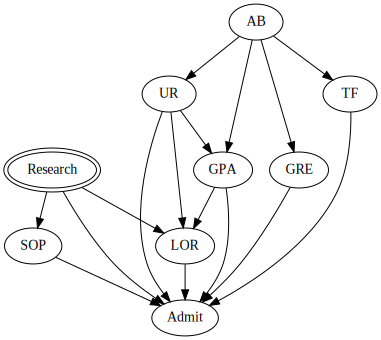

In [32]:
grad_doResearch = grad_latent.do("Research")
grad_doResearch.draw()

In [33]:
# backdoor criterion
grad_latent.get_all_backdoor_adjustment_sets("Research", "Admit")

frozenset({frozenset({'UR'}),
           frozenset({'GRE', 'UR'}),
           frozenset({'GPA', 'GRE', 'UR'}),
           frozenset({'AB', 'UR'}),
           frozenset({'AB', 'GPA', 'UR'}),
           frozenset({'TF', 'UR'}),
           frozenset({'GPA', 'UR'}),
           frozenset({'AB', 'TF', 'UR'}),
           frozenset({'AB', 'GPA', 'TF', 'UR'}),
           frozenset({'AB', 'GRE', 'TF', 'UR'}),
           frozenset({'GPA', 'TF', 'UR'}),
           frozenset({'GRE', 'TF', 'UR'}),
           frozenset({'AB', 'GRE', 'UR'}),
           frozenset({'GPA', 'GRE', 'TF', 'UR'}),
           frozenset({'AB', 'GPA', 'GRE', 'UR'}),
           frozenset({'AB', 'GPA', 'GRE', 'TF', 'UR'})})

## ATE Estimation

In [34]:
# copied from the third notebook of causal inference
def estimate_conditional_expectation(df, x, y):
    """
    Estimate E[Y|X=1] - E[Y|X=0]
    
    from a dataframe `df` of samples.
    
    Arguments
    ---------
    df: pandas.DataFrame
    
    x: str
    
    y: str
    
    Returns
    -------
    estimates: tuple[float, float]
        estiamted difference and standard deviation
    """
    a = df.loc[lambda df: df[x] == 0]
    b = df.loc[lambda df: df[x] == 1]
    
    n_a = a.shape[0]
    n_b = b.shape[0]
    
    delta = b[y].mean() - a[y].mean()
    delta_std = np.sqrt(a[y].var() / n_a + b[y].var() / n_b)
    
    return (delta, delta_std)


def ab_test(scm, x, y, n=10000):
    """
    Simulate an A/B on StructuralCausalModel scm
    to estimate the quantity:
    
    E[Y|do(X) = 1] - E[Y|do(X) = 0]
    
    Arguments
    ---------
    scm: StructuralCausalmodel
    
    x: str
    
    y: str
    
    Returns
    -------
    estimate: tuple[estimates, estiamte_std]
    
    """
    scm_do = scm.do(x)
    
    n_a = int(n / 2)
    n_b = n - n_a
    set_variable = np.array([0]*n_a + [1]*n_b)
    
    samp = (
        scm_do
        .sample(
            set_values={x: set_variable}, 
            n_samples=n)
    )
    
    return estimate_conditional_expectation(samp, x, y)

In [35]:
# ATE based on the continuous model
print("Estimated ATE: {:.3f}".format(ab_test(grad_cont, "Research", "Admit")[0]))

Estimated ATE: 0.035


In [36]:
# ATE based on the discrete model
print("Estimated ATE: {:.3f}".format(ab_test(grad_disc, "Research", "Admit")[0]))

Estimated ATE: 0.073


# Conclusion

Both the continuous and the discrete models show that intervening on the variable **Research** will increase a student's chance of admittance **Admit**, but it does not have much influence on it (the ATE value is small).

# Contribution

The correlation map -- credit to Elliot Brown

The idea of using customized function in StructuralCausalModel -- credit to Cory Glover

The discrete densities of **Research** and **SOP** -- credit to Joseph Drapeau

My own work: 

1. propose a confounding variable **AB**

2. propose a continuous model with specified structural assumptions

3. propose a discrete model (treat categorical variables) with specified structural assumptions

4. for both two models, write customized fitting functions that not only fit the corresponding distribution, but also process the prediction values to obey certain constraint. For example, in the continuous model, the continuous values of **UR** are forced to be integers from 1 to 5.

### Working Hours: 12